In [1]:
#  STEP 1: Install dependencies
! pip install rasterio tensorflow scikit-learn tqdm

#  STEP 2: Imports
import os
import numpy as np
import rasterio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt

#  STEP 3: Load all NDVI GeoTIFFs into a 3D array

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Unzip NDVI files from Google Drive
import shutil

zip_path = "/content/drive/MyDrive/ndvi_jan_june_2024.zip"
extract_to = "/content/ndvi_jan_june_2024"

# Copy zip to /content before unzipping
shutil.copy(zip_path, "/content/ndvi_jan_june_2024.zip")
!unzip -q /content/ndvi_jan_june_2024.zip -d /content/ndvi_jan_june_2024
!ls -R /content/ndvi_jan_june_2024

#  STEP 3: Load all NDVI GeoTIFFs into a 3D array
# folder = "/content/ndvi_tiffs"
folder = "/content/ndvi_jan_june_2024/ndvi_jan_june_2024"
files = sorted([f for f in os.listdir(folder) if f.endswith('.tif')])
print(files)

# print(files)
# exit()

ndvi_stack = []

print("Reading NDVI images...")


for f in files:
    with rasterio.open(os.path.join(folder, f)) as src:
        data = src.read(1).astype('float32')
        ndvi_stack.append(data)

print(type(ndvi_stack[0]))
ndvi_stack = np.array(ndvi_stack)  # Shape: [time, height, width]
time, height, width = ndvi_stack.shape

print(f"Loaded NDVI stack with shape: {ndvi_stack.shape}")

print("NDVI shape:", ndvi_stack.shape)
print("NDVI stats:", np.nanmin(ndvi_stack), np.nanmax(ndvi_stack))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 19.4 MB/s eta 0:00:00
Mounted at /content/drive
/content/ndvi_jan_june_2024:
ndvi_jan_june_2024

/content/ndvi_jan_june_2024/ndvi_jan_june_2024:
NDVI_01_January_2024_Krishna.tif   NDVI_04_April_2024_Krishna.tif
NDVI_02_February_2024_Krishna.tif  NDVI_05_May_2024_Krishna.tif
NDVI_03_March_2024_Krishna.tif	   NDVI_06_June_2024_Krishna.tif
['NDVI_01_January_2024_Krishna.tif', 'NDVI_02_February_2024_Krishna.tif', 'NDVI_03_March_2024_Krishna.tif', 'NDVI_04_April_2024_Krishna.tif', 'NDVI_05_May_2024_Krishna.tif', 'NDVI_06_June_2024_Krishna.tif']
Reading NDVI images...
<class 'numpy.ndarray'>
Loaded NDVI stack with shape: (6, 5308, 5811)
NDVI shape: (6, 5308, 5811)
NDVI stats: -0.9994874 0.99996793


In [2]:
ndvi_stack

for i, layer in enumerate(ndvi_stack):
    nans = np.isnan(layer).sum()
    print(f"Time step {i}: {nans} NaN values")

total_nans = np.isnan(ndvi_stack).sum()
print("Total NaN values in NDVI stack:", total_nans)

total_pixels = np.prod(ndvi_stack.shape)
nan_percentage = (total_nans / total_pixels) * 100
print(f"Percentage of NaN values: {nan_percentage:.2f}%")



Time step 0: 21085542 NaN values
Time step 1: 21042142 NaN values
Time step 2: 21024068 NaN values
Time step 3: 21023607 NaN values
Time step 4: 21025250 NaN values
Time step 5: 21025813 NaN values
Total NaN values in NDVI stack: 126226422
Percentage of NaN values: 68.21%


(6, 5308, 5811)
Pixels that are NaN in ALL timesteps: 21023606


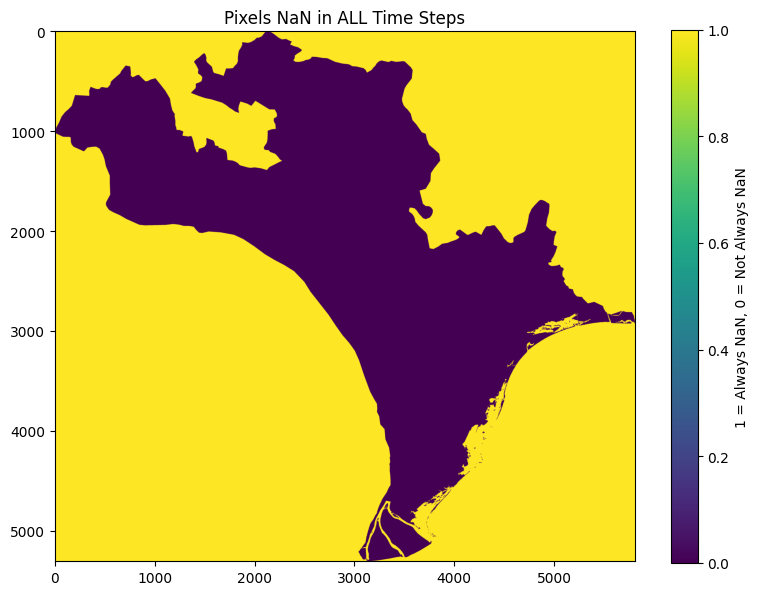

In [3]:
nan_masks = np.isnan(ndvi_stack)  # (time, height, width)
print(nan_masks.shape)

# --- Check where all time steps are NaN ---
consistent_nan_mask = np.all(nan_masks, axis=0)  # (height, width)
consistent_nan_count = np.sum(consistent_nan_mask)
print("Pixels that are NaN in ALL timesteps:", consistent_nan_count)

# --- Optional: visualize consistent NaN locations ---
plt.figure(figsize=(8, 6))
plt.imshow(consistent_nan_mask, cmap='viridis')
plt.title("Pixels NaN in ALL Time Steps")
plt.colorbar(label="1 = Always NaN, 0 = Not Always NaN")
plt.tight_layout()
plt.show()

In [4]:
ndvi_scaled = np.empty_like(ndvi_stack, dtype=np.float32)
mins = np.full((height, width), np.nan, dtype=np.float32)
maxs = np.full((height, width), np.nan, dtype=np.float32)

print("Normalizing pixels with NumPy...")
for i in tqdm(range(height)):
    for j in range(width):
        series = ndvi_stack[:, i, j]
        if np.isnan(series).any() or np.all(series == 0):
            ndvi_scaled[:, i, j] = np.nan
            continue
        min_val = np.nanmin(series)
        max_val = np.nanmax(series)
        if max_val - min_val == 0:
            ndvi_scaled[:, i, j] = np.nan
        else:
            ndvi_scaled[:, i, j] = (series - min_val) / (max_val - min_val)
            mins[i, j] = min_val
            maxs[i, j] = max_val


Normalizing pixels with NumPy...


100%|██████████| 5308/5308 [06:47<00:00, 13.01it/s]


In [5]:
import os
import numpy as np
import rasterio
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt



normalized=True
seq_length = 5  # Use 5 months to predict the 6th
X_all = []
y_all = []
coords_all = []
# valid_mask = np.ones((height, width), dtype=bool)
# for t in range(time):
#     valid_mask = valid_mask & ~np.isnan(ndvi_scaled[t])
print("Preparing training data...")
for i in tqdm(range(height)):
    for j in range(width):
        # if not valid_mask[i, j]:
        #     continue
        if normalized:
            series=ndvi_scaled[:, i, j]
        else:
            series = ndvi_stack[:, i, j]
        if np.isnan(series).any():
            continue

        # Use first 5 months to predict the 6th month
        X_all.append(series[:seq_length])
        y_all.append(series[seq_length])
        coords_all.append([i, j])

# Convert to numpy arrays and reshape for LSTM
X_all = np.array(X_all).reshape(-1, seq_length, 1)
y_all = np.array(y_all)
coords_all = np.array(coords_all)

print(f"Training data prepared: X shape: {X_all.shape}, y shape: {y_all.shape}")


Preparing training data...


100%|██████████| 5308/5308 [02:08<00:00, 41.39it/s]


Training data prepared: X shape: (9739882, 5, 1), y shape: (9739882,)


In [6]:

def create_lstm_model(seq_length):
    pixel_input = Input(shape=(seq_length, 1))  # NDVI time series input
    coord_input = Input(shape=(2,))  # Pixel coordinates (i, j)

    # LSTM layers
    # lstm_1 = LSTM(50, return_sequences=True)(pixel_input)
    lstm_1 = LSTM(32, return_sequences=True)(pixel_input)
    lstm_2 = LSTM(50)(lstm_1)

    # Concatenate LSTM output with coordinates for spatial awareness
    concat = Concatenate()([lstm_2, coord_input])

    # Output layer
    output = Dense(1)(concat)

    # Define the model
    model = tf.keras.Model(inputs=[pixel_input, coord_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model

print("Training LSTM model...")
model = create_lstm_model(seq_length)
model.fit(
    [X_all,coords_all],
    y_all,
    validation_split = 0.2,
    epochs=5,
    batch_size=2048,
    verbose=1
)
model_path = "/content/drive/MyDrive/ndvi_lstm_model_july_2024.keras"
model.save(model_path)

Training LSTM model...
Epoch 1/5
3805/3805 ━━━━━━━━━━━━━━━━━━━━ 316s 82ms/step - loss: 4635.8462 - val_loss: 0.5075
Epoch 2/5
3805/3805 ━━━━━━━━━━━━━━━━━━━━ 335s 86ms/step - loss: 0.1483 - val_loss: 0.2053
Epoch 3/5
3805/3805 ━━━━━━━━━━━━━━━━━━━━ 314s 82ms/step - loss: 0.1133 - val_loss: 0.3529
Epoch 4/5
3805/3805 ━━━━━━━━━━━━━━━━━━━━ 331s 85ms/step - loss: 0.1297 - val_loss: 0.2455
Epoch 5/5
3805/3805 ━━━━━━━━━━━━━━━━━━━━ 324s 85ms/step - loss: 0.1174 - val_loss: 0.3604


In [7]:
predicted = np.full((height, width), np.nan, dtype=np.float32)
print("prepring data for Predicting NDVI for the 7th month...")
# X_test=[]
# coords_test = []

# for i in tqdm(range(height)):
#     for j in range(width):
#         if normalized:
#             series=ndvi_scaled[:,i,j]
#         else:
#             series = ndvi_stack[:, i, j]
#         if np.isnan(series).any():
#             continue

#         # Use all 6 months to predict the 7th month

#         X_test.append(series[1:])
#         coords_test.append([i,j])

#         # # Inverse transform the prediction to original scale
#         # if scalers[i, j] is not None:
#         #     predicted[i, j] = scalers[i, j].inverse_transform(pred_scaled.reshape(-1, 1))[0][0]

# X_test = np.array(X_test).reshape(-1, seq_length, 1)
# coords_test = np.array(coords_test)
seq_length = 5
X_test = []
coords_test = []

for i in tqdm(range(height)):
    for j in range(width):
        series = ndvi_scaled[:, i, j] if normalized else ndvi_stack[:, i, j]
        if np.isnan(series).any():
            continue
        if len(series[1:]) < seq_length:
            continue  # skip if not enough data

        X_test.append(series[1:1+seq_length])  # get exactly 6 months
        coords_test.append([i, j])

X_test = np.array(X_test).reshape(-1, seq_length, 1)
coords_test = np.array(coords_test)

prepring data for Predicting NDVI for the 7th month...


100%|██████████| 5308/5308 [02:12<00:00, 40.06it/s]


In [8]:
print("predicting for 7th month")
y_pred = model.predict([X_test, coords_test], batch_size=2048, verbose=1)

print("converting back to 2d grid")
print(y_pred.shape)
for idx, (i, j) in tqdm(enumerate(coords_test)):
    if normalized:
        min_val = mins[i, j]
        max_val = maxs[i, j]
        assert not np.isnan(min_val) and not np.isnan(max_val)
        predicted[i, j] = y_pred[idx] * (maxs[i,j]-mins[i,j]) + mins[i,j]
    else:
        predicted[i, j] = y_pred[idx]

predicting for 7th month
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 163s 34ms/step
converting back to 2d grid
(9739882, 1)


0it [00:00, ?it/s]<ipython-input-8-2dbf15bb067a>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted[i, j] = y_pred[idx] * (maxs[i,j]-mins[i,j]) + mins[i,j]
9739882it [01:49, 89215.16it/s] 


Saving prediction to GeoTIFF...
Prediction saved as: predicted_ndvi_july_2024.tif


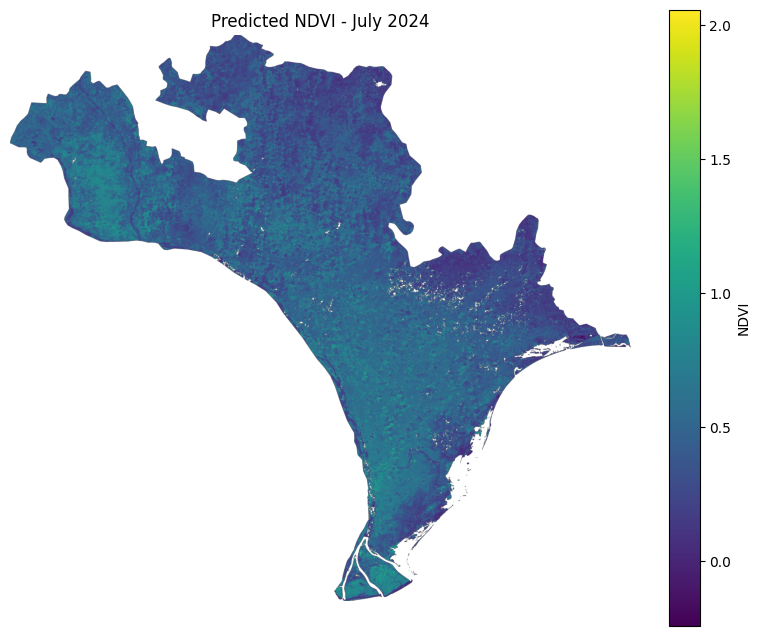

In [9]:
# STEP 6: Save prediction as GeoTIFF
print("Saving prediction to GeoTIFF...")#
# Use last image as template
with rasterio.open(os.path.join(folder, files[-1])) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=1)
    with rasterio.open("/content/drive/MyDrive/predicted_ndvi_july_2024.tif", "w", **profile) as dst:
        dst.write(predicted.astype(np.float32), 1)#
print("Prediction saved as: predicted_ndvi_july_2024.tif")#
# STEP 7: Preview the prediction
plt.figure(figsize=(10, 8))
plt.imshow(predicted, cmap='viridis')
plt.colorbar(label='NDVI')
plt.title("Predicted NDVI - July 2024")
plt.axis('off')
plt.savefig("/content/drive/MyDrive/predicted_ndvi_july_2024.png", dpi=300)
plt.show()